In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product c.csv', parse_dates=['Month-Year'])


In [3]:
sales_c= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_c = sales_c.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_c.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,496334,1002744,1578266
1,2019-02-01,306455,619142,974480
2,2019-03-01,476270,962208,1514466
3,2019-04-01,628463,1269687,1998416
4,2019-05-01,366750,740950,1166209


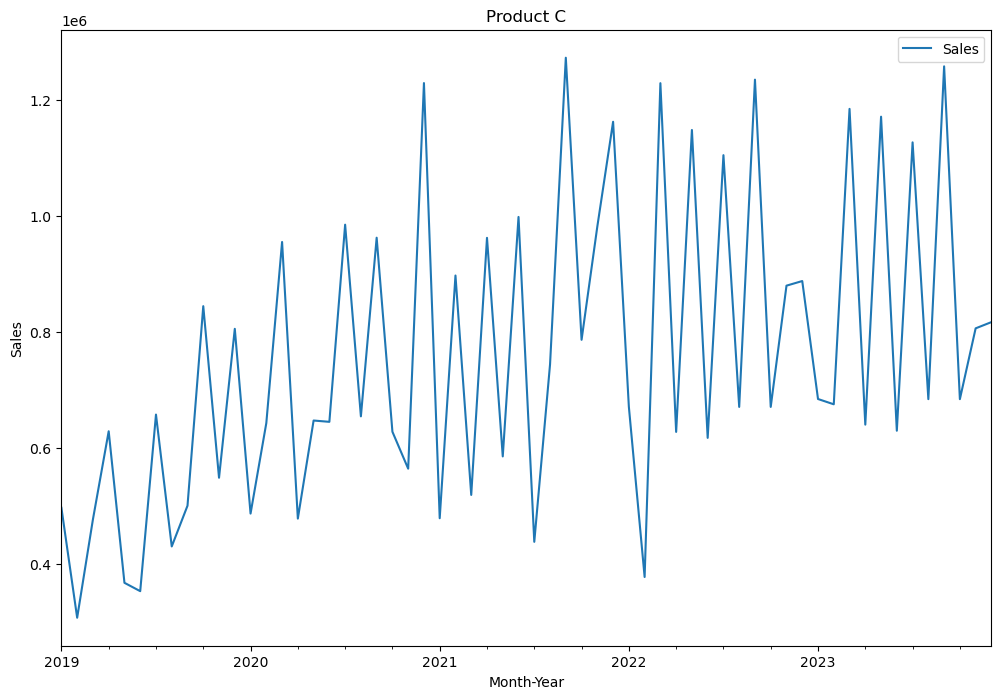

In [5]:
ax = sales_c.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product C')
plt.legend(['Sales'])
plt.show()

In [6]:
train= sales_c[:54]
test=sales_c[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

23:27:22 - cmdstanpy - INFO - Chain [1] start processing
23:27:26 - cmdstanpy - INFO - Chain [1] done processing
23:27:32 - cmdstanpy - INFO - Chain [1] start processing
23:27:32 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing
23:28:20 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:25 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   133267.003738  
1   119570.285668  
2   126838.441086  
3   134051.867391  
4   130368.285219  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
1,0.001,0.01,multiplicative,119570.285668
36,0.200,0.01,additive,121234.093176
24,0.100,0.01,additive,121366.036954
60,0.500,0.01,additive,121375.259819
48,0.300,0.01,additive,121402.314444
...,...,...,...,...
35,0.100,10.00,multiplicative,136271.998567
68,0.500,5.00,additive,138258.283753
52,0.300,1.00,additive,139066.592002
56,0.300,5.00,additive,139291.196688


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01, seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_c['Market Size']
future_dates['Marketing Expense'] = sales_c['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,1002744,1578266
1,2019-02-01,619142,974480
2,2019-03-01,962208,1514466
3,2019-04-01,1269687,1998416
4,2019-05-01,740950,1166209
5,2019-06-01,711811,1120336
6,2019-07-01,1327952,2090113
7,2019-08-01,867822,1365910
8,2019-09-01,1009971,1589625
9,2019-10-01,1107516,1743167


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,1.145702e+06,8.899368e+05,1.395659e+06
55,2023-08-01,7.477698e+05,4.808297e+05,1.006152e+06
56,2023-09-01,1.262942e+06,1.005616e+06,1.521629e+06
57,2023-10-01,8.549084e+05,5.784321e+05,1.134876e+06
58,2023-11-01,8.410977e+05,5.852279e+05,1.089785e+06
59,2023-12-01,7.825815e+05,5.171254e+05,1.056509e+06


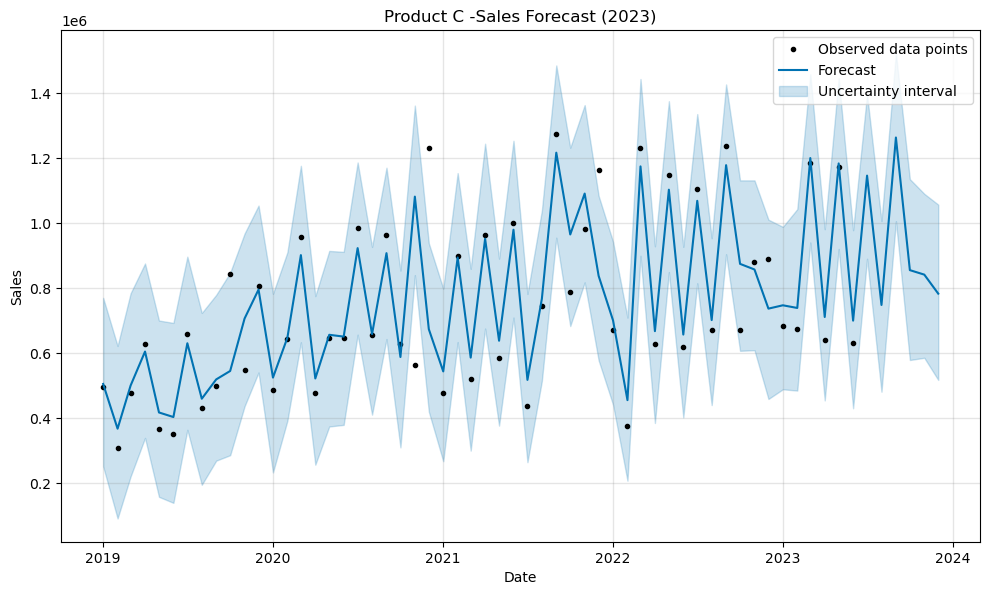

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

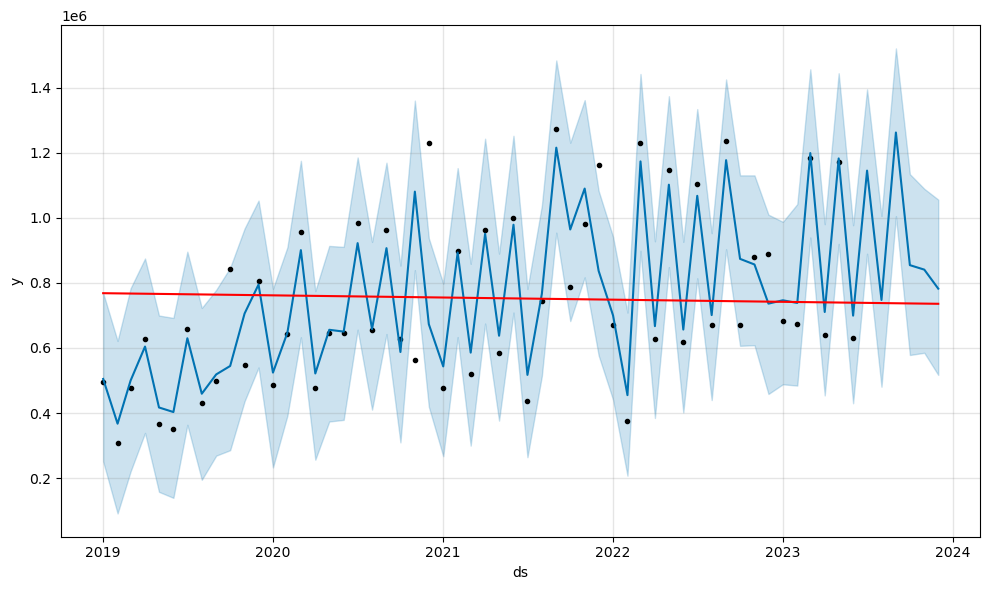

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

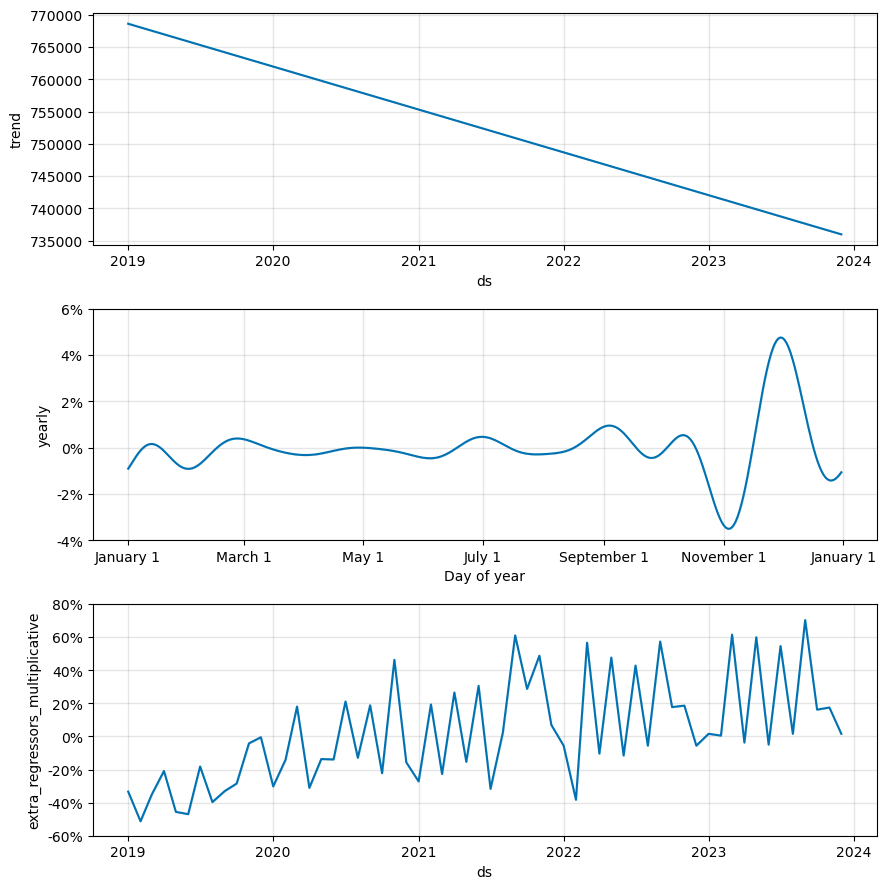

In [21]:
fig2 = model.plot_components(forecast)

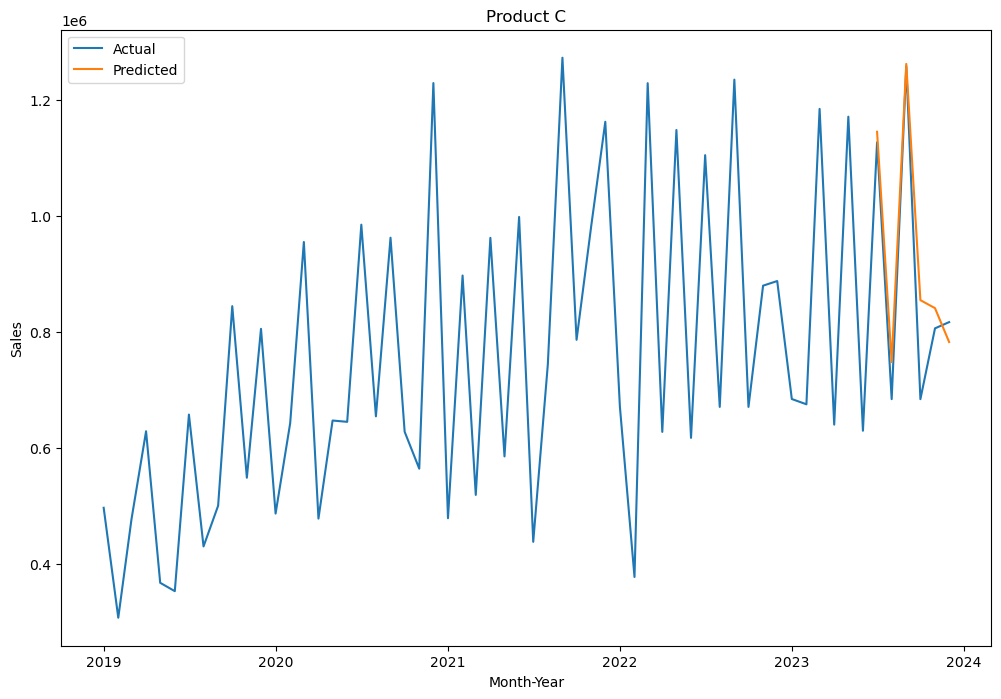

In [22]:
# Reset index of sales_b DataFrame
sales_c_reset_index = sales_c.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_c_reset_index['ds'], sales_c_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product C')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 54433.097
MAPE - FB PROPHET: 0.075
MSE - FB PROPHET: 6009809335.679
RMSE - FB PROPHET: 77522.960


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,1.485981e+10,121900.824391,110226.969051,0.228821,0.228821,0.198005,1.0
1,25 days,1.891240e+09,43488.393157,39068.199726,0.052394,0.052394,0.050674,1.0
2,29 days,4.297894e+09,65558.324915,55251.822662,0.075198,0.075198,0.071174,1.0
3,51 days,6.455787e+09,80347.912676,79599.871442,0.112307,0.112307,0.106165,1.0
4,55 days,1.101370e+10,104946.182767,100120.193412,0.220745,0.220745,0.192755,1.0
5,56 days,1.062370e+10,103071.331714,97151.833725,0.221378,0.221378,0.193333,1.0
6,60 days,6.308631e+09,79426.889175,77953.335105,0.115793,0.115793,0.109247,1.0
7,82 days,7.635176e+09,87379.495862,87172.617140,0.100884,0.100884,0.097476,1.0
8,83 days,6.216767e+09,78846.476744,78811.389460,0.062954,0.062954,0.065001,1.0
9,87 days,3.683681e+09,60693.335079,57731.757029,0.046872,0.046872,0.048123,1.0


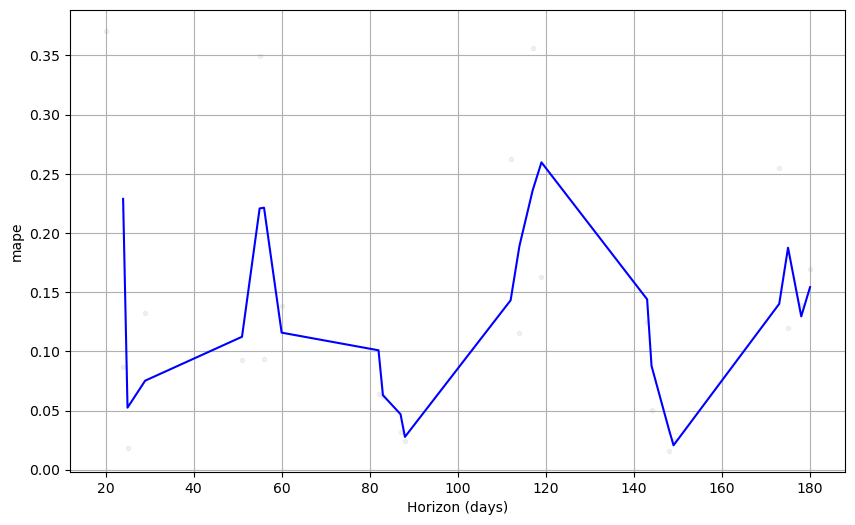

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54    1127413
55     683935
56    1258717
57     683935
58     806218
59     816978
Name: y, dtype: int64

In [30]:
pred

54    1.145702e+06
55    7.477698e+05
56    1.262942e+06
57    8.549084e+05
58    8.410977e+05
59    7.825815e+05
Name: yhat, dtype: float64